# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

## CSV 1

In [1]:
# Write the code here and add cells as you need
import numpy as np
import pandas as pd
import zipfile
import os

In [2]:
# The uploaded zip file name
zip_file_name = 'combined.zip'

# Csv file name
csv_file_name = 'combined_csv_v1.csv'

# The directory to extract the files to (it will be created if it doesn't exist)
extract_dir = 'extracted_files'

# Ensure the directory exists
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file and extract its contents
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Construct the path to the CSV file
csv_file_path = os.path.join(extract_dir, csv_file_name)

# reading the CSV file using pandas
data = pd.read_csv(csv_file_path,  nrows = 1000000)
data.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Split the data into 70% train, 15% validation, and 15% test
train_frac = 0.70
val_frac = 0.15 / (1 - train_frac)  # Calculate fraction of remaining data

# Splitting the datasets
training_dataset = data.sample(frac=train_frac, random_state=59)
remaining_dataset = data.loc[~data.index.isin(training_dataset.index), :]

validation_dataset = remaining_dataset.sample(frac=val_frac, random_state=59)
testing_dataset = remaining_dataset.loc[~remaining_dataset.index.isin(validation_dataset.index), :]


In [4]:
print(data.shape)
print(training_dataset.shape)
print(validation_dataset.shape)
print(testing_dataset.shape)

(1000000, 94)
(700000, 94)
(150000, 94)
(150000, 94)


In [5]:
import sagemaker
import boto3
from sagemaker import TrainingInput
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator
import pandas as pd
from sklearn.model_selection import train_test_split
import io
# Intitialising sagemaker
# SageMaker session and default S3 bucket
session = sagemaker.Session()
default_bucket = session.default_bucket()
data_prefix = 'model-data'

# Define AWS region and container for Linear Learner
aws_region = boto3.Session().region_name
linear_container = get_image_uri(aws_region, 'linear-learner')


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [6]:
# Pre-processing for S3
# Splitting data
def process_and_upload_data(dataframe, file_name, s3_prefix):
    dataframe.to_csv(file_name, header=False, index=False)
    return session.upload_data(file_name, key_prefix=s3_prefix)

train_path = process_and_upload_data(training_dataset, 'training_data.csv', f"{data_prefix}/train")
valid_path = process_and_upload_data(validation_dataset, 'validation_data.csv', f"{data_prefix}/valid")
test_path = process_and_upload_data(testing_dataset, 'testing_data.csv', f"{data_prefix}/test")


In [7]:
# Model Configuration and training
sm_role = sagemaker.get_execution_role()
linear_config = {
    'image_uri': linear_container,
    'role': sm_role,
    'instance_count': 1,
    'instance_type': 'ml.m4.xlarge',
    'output_path': f's3://{default_bucket}/{data_prefix}/output'
}

linear_model = Estimator(**linear_config)
linear_model.set_hyperparameters(predictor_type='binary_classifier', mini_batch_size=1000, epochs=3)

# Data channels
channels = {
    'train': TrainingInput(train_path, content_type='text/csv'),
    'validation': TrainingInput(valid_path, content_type='text/csv')
}

linear_model.fit(channels)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-02-15-15-33-140


2023-11-02 15:15:33 Starting - Starting the training job...
2023-11-02 15:15:59 Starting - Preparing the instances for training.........
2023-11-02 15:17:32 Downloading - Downloading input data......
2023-11-02 15:18:12 Training - Downloading the training image......
2023-11-02 15:19:13 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/02/2023 15:19:30 INFO 140062760535872] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'lo

In [8]:
# Prepare test data for batch transform
batch_input = testing_dataset.drop(columns=['target'])  
batch_input.to_csv('batch_input.csv', index=False, header=False)
batch_input_path = session.upload_data('batch_input.csv', key_prefix=f"{data_prefix}/batch_input")

# Batch transform settings and execution
output_location = f's3://{default_bucket}/{data_prefix}/batch_output'

transformer = linear_model.transformer(
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=output_location,
    max_payload=5, # Setting max_payload to a value less than or equal to 6 (MB) for the particular instance
    strategy='MultiRecord'
)

transformer.transform(
    data=batch_input_path,
    content_type='text/csv',
    split_type='Line'
)
transformer.wait()


INFO:sagemaker:Creating model with name: linear-learner-2023-11-02-15-22-22-738
INFO:sagemaker:Creating transform job with name: linear-learner-2023-11-02-15-22-23-383


.............................................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2023 15:29:52 INFO 140706763048768] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/02/2023 15:29:56 WARNING 140706763048768] Loggers have already been setup.
[11/02/2023 15:29:56 INFO 140706763048768] loaded entry point class algorithm.serve.server_config:config_api
[11/02/2023 15:29:56 INFO 140706763048768] loading entry points
[11/02/2023

In [9]:
# Fetch results from S3
s3_client = boto3.client('s3')
result_file = s3_client.get_object(Bucket=default_bucket, Key=f"{data_prefix}/batch_output/batch_input.csv.out")
predicted_data = pd.read_csv(io.BytesIO(result_file['Body'].read()), header=None, names=['Predicted'])
print(predicted_data.head())


                                     Predicted
{"predicted_label":0  score:0.137906938791275}
{"predicted_label":0  score:0.182445704936981}
{"predicted_label":0  score:0.169826030731201}
{"predicted_label":0  score:0.222312852740287}
{"predicted_label":0  score:0.177640259265899}


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
test_labels = testing_dataset.loc[:, 'target'].values

# Function for plotting confusion matrx
def plot_confusion_matrix(test_labels, predicted_data, title='Confusion Matrix for 1st csv'):
    conf_matrix = confusion_matrix(test_labels, predicted_data)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Oranges', 
                xticklabels=['No Delay', 'Delay'], 
                yticklabels=['No Delay', 'Delay'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    

INFO:matplotlib.font_manager:generated new fontManager


In [11]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

target_predictions = [int(label[-1]) for label in predicted_data.index]

# Calculate metrics
accuracy = accuracy_score(test_labels, target_predictions)
recall = recall_score(test_labels, target_predictions)
precision = precision_score(test_labels, target_predictions)
f1 = f1_score(test_labels, target_predictions)
tn, fp, fn, tp = confusion_matrix(test_labels, target_predictions).ravel()
# Calculate specificity
specificity = tn / (tn + fp)
# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Specificity:{specificity:.2f}")

Accuracy: 0.78
Recall: 0.01
Precision: 0.52
F1 Score: 0.03
Specificity:1.00


In [12]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, target_predictions))

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88    117467
         1.0       0.52      0.01      0.03     32533

    accuracy                           0.78    150000
   macro avg       0.65      0.51      0.45    150000
weighted avg       0.73      0.78      0.69    150000



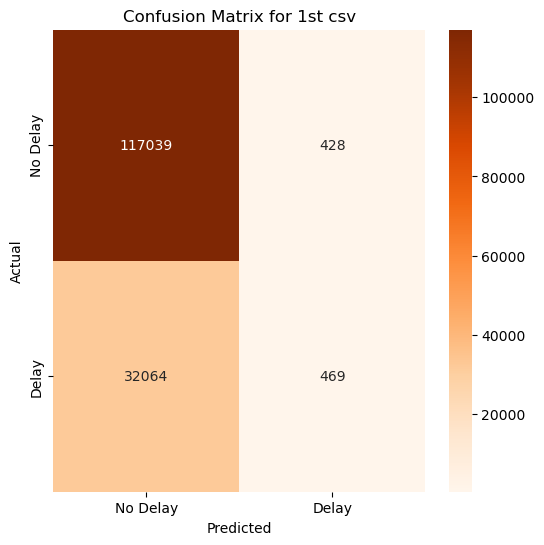

In [13]:
plot_confusion_matrix(test_labels, target_predictions)

## CSV 2

In [14]:
# The uploaded zip file name
zip_file_name = 'combined.zip'

# Csv file name
csv_file_name = 'combined_csv_v2.csv'

# The directory to extract the files to (it will be created if it doesn't exist)
extract_dir = 'extracted_files'

# Ensure the directory exists
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file and extract its contents
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Construct the path to the CSV file
csv_file_path = os.path.join(extract_dir, csv_file_name)

# Reading the CSV file using pandas
data = pd.read_csv(csv_file_path,  nrows = 1000000)
data.head()

,target,Distance,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,SNOW_D,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
0,0.0,689.0,33,0,54.0,30,0,130.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0.0,731.0,39,0,136.0,33,0,54.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,33,0,54.0,77,0,68.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,1587.0,33,0,54.0,20,0,165.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,0.0,1587.0,20,0,165.0,33,0,54.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Split the data into 70% train, 15% validation, and 15% test
train_frac = 0.70
val_frac = 0.15 / (1 - train_frac)  # Calculate fraction of remaining data

# Splitting the datasets
training_dataset = data.sample(frac=train_frac, random_state=59)
remaining_dataset = data.loc[~data.index.isin(training_dataset.index), :]

validation_dataset = remaining_dataset.sample(frac=val_frac, random_state=59)
testing_dataset = remaining_dataset.loc[~remaining_dataset.index.isin(validation_dataset.index), :]

In [16]:
print(data.shape)
print(training_dataset.shape)
print(validation_dataset.shape)
print(testing_dataset.shape)

(1000000, 107)
(700000, 107)
(150000, 107)
(150000, 107)


In [17]:
# Intitialising sagemaker
# SageMaker session and default S3 bucket
session = sagemaker.Session()
default_bucket = session.default_bucket()
data_prefix = 'model-data'

# Define AWS region and container for Linear Learner
aws_region = boto3.Session().region_name
linear_container = get_image_uri(aws_region, 'linear-learner')


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [18]:
# Pre-processing for S3
# Splitting the data
def process_and_upload_data(dataframe, file_name, s3_prefix):
    dataframe.to_csv(file_name, header=False, index=False)
    return session.upload_data(file_name, key_prefix=s3_prefix)

train_path = process_and_upload_data(training_dataset, 'training_data.csv', f"{data_prefix}/train")
valid_path = process_and_upload_data(validation_dataset, 'validation_data.csv', f"{data_prefix}/valid")
test_path = process_and_upload_data(testing_dataset, 'testing_data.csv', f"{data_prefix}/test")


In [19]:
# Model Configuration and training
sm_role = sagemaker.get_execution_role()
linear_config = {
    'image_uri': linear_container,
    'role': sm_role,
    'instance_count': 1,
    'instance_type': 'ml.m5.large',
    'output_path': f's3://{default_bucket}/{data_prefix}/output'
}

linear_model = Estimator(**linear_config)
linear_model.set_hyperparameters(predictor_type='binary_classifier', mini_batch_size=1000, epochs=3)

# Data channels
channels = {
    'train': TrainingInput(train_path, content_type='text/csv'),
    'validation': TrainingInput(valid_path, content_type='text/csv')
}

linear_model.fit(channels)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-02-15-31-18-876


2023-11-02 15:31:19 Starting - Starting the training job...
2023-11-02 15:31:36 Starting - Preparing the instances for training......
2023-11-02 15:32:47 Downloading - Downloading input data......
2023-11-02 15:33:42 Training - Downloading the training image......
2023-11-02 15:34:43 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/02/2023 15:34:49 INFO 140479975774016] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss'

In [20]:
# Prepare test data for batch transform
batch_input = testing_dataset.drop(columns=['target'])  
batch_input.to_csv('batch_input.csv', index=False, header=False)
batch_input_path = session.upload_data('batch_input.csv', key_prefix=f"{data_prefix}/batch_input")

# Batch transform settings and execution
output_location = f's3://{default_bucket}/{data_prefix}/batch_output'

transformer = linear_model.transformer(
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=output_location,
    max_payload=5, # Setting max_payload to a value less than or equal to 6 (MB) for the particular instance
    strategy='MultiRecord'
)

transformer.transform(
    data=batch_input_path,
    content_type='text/csv',
    split_type='Line'
)
transformer.wait()


INFO:sagemaker:Creating model with name: linear-learner-2023-11-02-15-37-38-311
INFO:sagemaker:Creating transform job with name: linear-learner-2023-11-02-15-37-38-934


.............................................
Docker entrypoint called with argument(s): serve
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2023 15:45:09 INFO 140245240018752] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
Running default environment configuration script
[11/02/2023 15:45:09 INFO 140245240018752] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/sci

In [21]:
# Fetch results from S3
s3_client = boto3.client('s3')
result_file = s3_client.get_object(Bucket=default_bucket, Key=f"{data_prefix}/batch_output/batch_input.csv.out")
predicted_data = pd.read_csv(io.BytesIO(result_file['Body'].read()), header=None, names=['Predicted'])
print(predicted_data.head())


                                     Predicted
{"predicted_label":0  score:0.114122569561004}
{"predicted_label":0  score:0.187572345137596}
{"predicted_label":0  score:0.158958971500396}
{"predicted_label":0  score:0.207478865981102}
{"predicted_label":0  score:0.169455140829086}


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
test_labels = testing_dataset.loc[:, 'target'].values

# Function for plotting confusion matrx
def plot_confusion_matrix(test_labels, predicted_data, title='Confusion Matrix for 2nd csv'):
    conf_matrix = confusion_matrix(test_labels, predicted_data)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Oranges', 
                xticklabels=['No Delay', 'Delay'], 
                yticklabels=['No Delay', 'Delay'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

In [23]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

target_predictions = [int(label[-1]) for label in predicted_data.index]

# Calculate metrics
accuracy = accuracy_score(test_labels, target_predictions)
recall = recall_score(test_labels, target_predictions)
precision = precision_score(test_labels, target_predictions)
f1 = f1_score(test_labels, target_predictions)
tn, fp, fn, tp = confusion_matrix(test_labels, target_predictions).ravel()
# Calculate specificity
specificity = tn / (tn + fp)
# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Specificity:{specificity:.2f}")

Accuracy: 0.79
Recall: 0.08
Precision: 0.59
F1 Score: 0.15
Specificity:0.98


In [24]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, target_predictions))

              precision    recall  f1-score   support

         0.0       0.79      0.98      0.88    117467
         1.0       0.59      0.08      0.15     32533

    accuracy                           0.79    150000
   macro avg       0.69      0.53      0.51    150000
weighted avg       0.75      0.79      0.72    150000



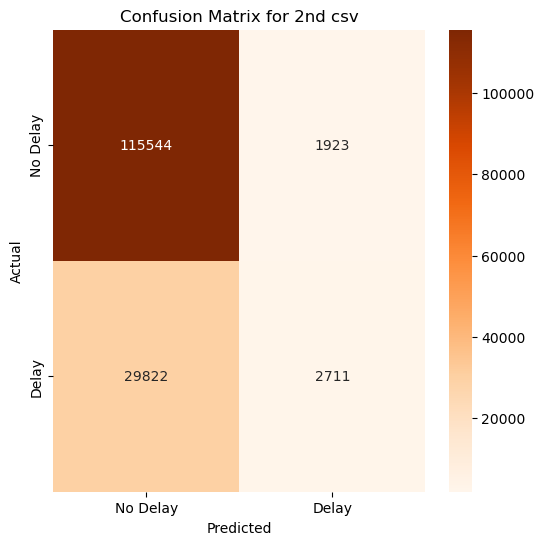

In [25]:
plot_confusion_matrix(test_labels, target_predictions)

# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

## CSV 1 - XGB


In [26]:
# The uploaded zip file name
zip_file_name = 'combined.zip'

# Csv file name
csv_file_name = 'combined_csv_v1.csv'

# The directory to extract the files to (it will be created if it doesn't exist)
extract_dir = 'extracted_files'

# Ensure the directory exists
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file and extract its contents
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Construct the path to the CSV file
csv_file_path = os.path.join(extract_dir, csv_file_name)

# Reading the CSV file using pandas
data = pd.read_csv(csv_file_path,  nrows = 1000000)
data.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator

# Start a SageMaker session
sess = sagemaker.Session()

# Get the default S3 bucket
bucket = sess.default_bucket()

# Define the prefix for storing data
prefix = 'ensemble-data'

# Upload the datasets to S3 and define the paths
training_data_path = sess.upload_data(path='training_data.csv', key_prefix=prefix + '/input/training')
validation_data_path = sess.upload_data(path='validation_data.csv', key_prefix=prefix + '/input/validation')

# Get the image URI for the XGBoost container
region = boto3.Session().region_name    
container = get_image_uri(region, 'xgboost', repo_version='1.0-1')

# Create an XGBoost estimator
role = get_execution_role()
xgb_estimator = Estimator(container,
                          role=role, 
                          instance_count=1,
                          instance_type='ml.m4.xlarge',
                          output_path=f's3://{bucket}/{prefix}/output')

# Set hyperparameters for the XGBoost algorithm
xgb_estimator.set_hyperparameters(objective='binary:logistic',  
                                  num_round=100,
                                  early_stopping_rounds=10)

# Define data channels
training_data_channel = TrainingInput(s3_data=training_data_path, content_type='text/csv')
validation_data_channel = TrainingInput(s3_data=validation_data_path, content_type='text/csv')

# Fit the estimator
xgb_estimator.fit({'train': training_data_channel, 'validation': validation_data_channel})

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-02-15-46-00-439


2023-11-02 15:46:00 Starting - Starting the training job......
2023-11-02 15:46:36 Starting - Preparing the instances for training......
2023-11-02 15:47:42 Downloading - Downloading input data...
2023-11-02 15:48:22 Training - Downloading the training image......
2023-11-02 15:49:02 Training - Training image download completed. Training in progress.[2023-11-02 15:49:19.552 ip-10-0-129-17.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined

In [28]:
batch_test = testing_dataset.drop(columns=['target'])
batch_test.to_csv('batch_test.csv', index=False, header=False)

# Upload the test dataset to S3
batch_test_filepath = sess.upload_data(path='batch_test.csv', key_prefix=prefix + '/input/testing')
print(f"Test data uploaded to: {batch_test_filepath}")

Test data uploaded to: s3://sagemaker-us-east-1-767055181084/ensemble-data/input/testing/batch_test.csv


In [29]:
# Set up the batch transform job
batch_output = f's3://{bucket}/{prefix}/batch-out/'
xgb_transformer = xgb_estimator.transformer(
    instance_count=1,
    instance_type='ml.c5.9xlarge',
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=batch_output
)

# Start the batch transform job
xgb_transformer.transform(
    data=batch_test_filepath,
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line'
)
xgb_transformer.wait()
print(f"Batch Transform complete. Output in: {batch_output}")

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-02-15-52-50-326
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-02-15-52-50-940


.................................
[2023-11-02:15:58:14:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:15:58:14:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:15:58:14:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
[2023-11-02:15:58:14:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:15:58:14:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:15:58:14:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocat

In [30]:
# Download the results
output_key_prefix = f"{prefix}/batch-out/batch_test.csv.out"
local_output_path = 'batch_results.csv'
s3_client = boto3.client('s3')
s3_client.download_file(bucket, output_key_prefix, local_output_path)
print(f"Output file downloaded to: {local_output_path}")


Output file downloaded to: batch_results.csv


In [31]:
# Load the results
predictions = pd.read_csv(local_output_path, header=None)
predictions.columns = ['Predicted']
test_labels = testing_dataset.loc[:, 'target'].values
# Convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (predictions['Predicted'] >= threshold).astype(int)

# Calculate metrics
report = classification_report(test_labels, binary_predictions)
accuracy = accuracy_score(test_labels, binary_predictions)

# Print the metrics
print(report)
print(f"Accuracy: {accuracy:.4f}")


              precision    recall  f1-score   support

         0.0       0.81      0.98      0.89    117467
         1.0       0.68      0.18      0.29     32533

    accuracy                           0.80    150000
   macro avg       0.75      0.58      0.59    150000
weighted avg       0.78      0.80      0.76    150000

Accuracy: 0.8042


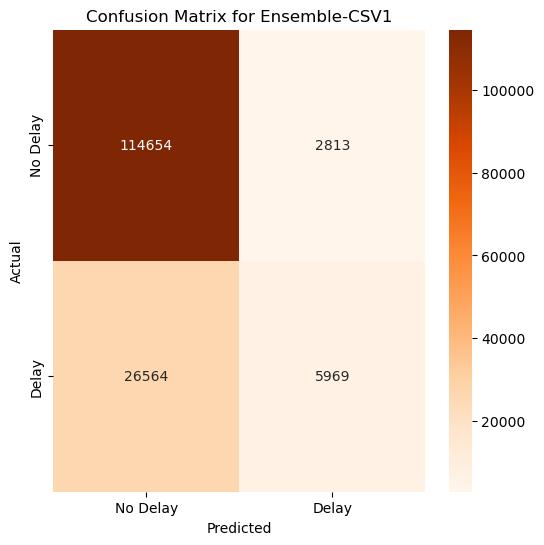

In [32]:
def plot_confusion_matrix(test_labels, predicted_data, title='Confusion Matrix for Ensemble-CSV1'):
    conf_matrix = confusion_matrix(test_labels, predicted_data)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Oranges', 
                xticklabels=['No Delay', 'Delay'], 
                yticklabels=['No Delay', 'Delay'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
plot_confusion_matrix(test_labels, binary_predictions)

In [33]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


# Calculate metrics
accuracy = accuracy_score(test_labels, binary_predictions)
recall = recall_score(test_labels, binary_predictions)
precision = precision_score(test_labels, binary_predictions)
f1 = f1_score(test_labels, binary_predictions)
tn, fp, fn, tp = confusion_matrix(test_labels, binary_predictions).ravel()
# Calculate specificity
specificity = tn / (tn + fp)
# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Specificity:{specificity:.2f}")

Accuracy: 0.80
Recall: 0.18
Precision: 0.68
F1 Score: 0.29
Specificity:0.98


## CSV 2 -xgb

In [34]:
# The uploaded zip file name
zip_file_name = 'combined.zip'

# Csv file name
csv_file_name = 'combined_csv_v2.csv'

# The directory to extract the files to (it will be created if it doesn't exist)
extract_dir = 'extracted_files'

# Ensure the directory exists
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file and extract its contents
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Construct the path to the CSV file
csv_file_path = os.path.join(extract_dir, csv_file_name)

# Now, you can read the CSV file using pandas
data = pd.read_csv(csv_file_path,  nrows = 1000000)
data.head()

,target,Distance,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,SNOW_D,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
0,0.0,689.0,33,0,54.0,30,0,130.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0.0,731.0,39,0,136.0,33,0,54.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,33,0,54.0,77,0,68.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,1587.0,33,0,54.0,20,0,165.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,0.0,1587.0,20,0,165.0,33,0,54.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator

# Start a SageMaker session
sess = sagemaker.Session()

# Get the default S3 bucket
bucket = sess.default_bucket()

# Define the prefix for storing data
prefix = 'ensemble-data'

# Upload the datasets to S3 and define the paths
training_data_path = sess.upload_data(path='training_data.csv', key_prefix=prefix + '/input/training')
validation_data_path = sess.upload_data(path='validation_data.csv', key_prefix=prefix + '/input/validation')


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [36]:
# Get the image URI for the XGBoost container
region = boto3.Session().region_name    
container = get_image_uri(region, 'xgboost', repo_version='1.0-1')

# Create an XGBoost estimator
role = get_execution_role()
xgb_estimator = Estimator(container,
                          role=role, 
                          instance_count=1,
                          instance_type='ml.m4.xlarge',
                          output_path=f's3://{bucket}/{prefix}/output')

# Set hyperparameters for the XGBoost algorithm
xgb_estimator.set_hyperparameters(objective='binary:logistic',  
                                  num_round=100,
                                  early_stopping_rounds=10)

# Define data channels
training_data_channel = TrainingInput(s3_data=training_data_path, content_type='text/csv')
validation_data_channel = TrainingInput(s3_data=validation_data_path, content_type='text/csv')

# Fit the estimator
xgb_estimator.fit({'train': training_data_channel, 'validation': validation_data_channel})

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-02-15-59-13-582


2023-11-02 15:59:13 Starting - Starting the training job...
2023-11-02 15:59:39 Starting - Preparing the instances for training.........
2023-11-02 16:01:06 Downloading - Downloading input data......
2023-11-02 16:01:48 Training - Downloading the training image...
2023-11-02 16:02:19 Training - Training image download completed. Training in progress.[2023-11-02 16:02:33.353 ip-10-2-103-210.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determine

In [37]:
batch_test = testing_dataset.drop(columns=['target'])
batch_test.to_csv('batch_test.csv', index=False, header=False)

# Upload the test dataset to S3
batch_test_filepath = sess.upload_data(path='batch_test.csv', key_prefix=prefix + '/input/testing')
print(f"Test data uploaded to: {batch_test_filepath}")

Test data uploaded to: s3://sagemaker-us-east-1-767055181084/ensemble-data/input/testing/batch_test.csv


In [38]:
# Set up the batch transform job
batch_output = f's3://{bucket}/{prefix}/batch-out/'
xgb_transformer = xgb_estimator.transformer(
    instance_count=1,
    instance_type='ml.c5.9xlarge',
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=batch_output
)

# Start the batch transform job
xgb_transformer.transform(
    data=batch_test_filepath,
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line'
)
xgb_transformer.wait()
print(f"Batch Transform complete. Output in: {batch_output}")

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-02-16-06-04-591
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-02-16-06-05-348


....................................[2023-11-02:16:12:10:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:16:12:10:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:16:12:10:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-11-02 16:12:10 +0000] [83] [INFO] Starting

In [39]:
# Download the results
output_key_prefix = f"{prefix}/batch-out/batch_test.csv.out"
local_output_path = 'batch_results.csv'
s3_client = boto3.client('s3')
s3_client.download_file(bucket, output_key_prefix, local_output_path)
print(f"Output file downloaded to: {local_output_path}")


Output file downloaded to: batch_results.csv


In [40]:
# Load the results
predictions = pd.read_csv(local_output_path, header=None)
predictions.columns = ['Predicted']
test_labels = testing_dataset.loc[:, 'target'].values
# Convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (predictions['Predicted'] >= threshold).astype(int)

# Calculate metrics
report = classification_report(test_labels, binary_predictions)
accuracy = accuracy_score(test_labels, binary_predictions)

# Print the metrics
print(report)
print(f"Accuracy: {accuracy:.4f}")


              precision    recall  f1-score   support

         0.0       0.81      0.98      0.89    117467
         1.0       0.68      0.18      0.29     32533

    accuracy                           0.80    150000
   macro avg       0.75      0.58      0.59    150000
weighted avg       0.78      0.80      0.76    150000

Accuracy: 0.8042


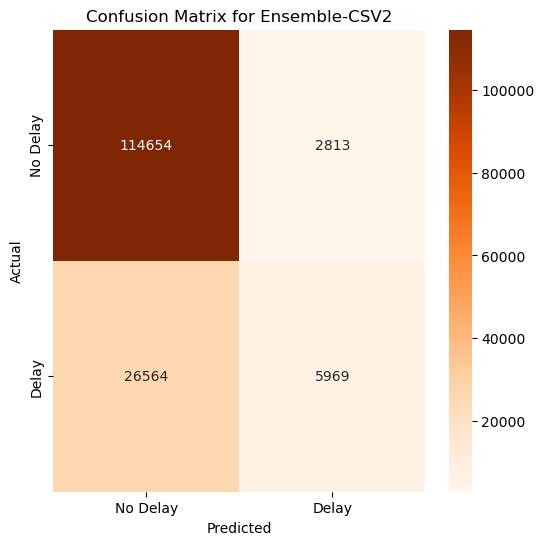

In [41]:
def plot_confusion_matrix(test_labels, predicted_data, title='Confusion Matrix for Ensemble-CSV2'):
    conf_matrix = confusion_matrix(test_labels, predicted_data)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Oranges', 
                xticklabels=['No Delay', 'Delay'], 
                yticklabels=['No Delay', 'Delay'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
plot_confusion_matrix(test_labels, binary_predictions)

In [42]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


# Calculate metrics
accuracy = accuracy_score(test_labels, binary_predictions)
recall = recall_score(test_labels, binary_predictions)
precision = precision_score(test_labels, binary_predictions)
f1 = f1_score(test_labels, binary_predictions)
tn, fp, fn, tp = confusion_matrix(test_labels, binary_predictions).ravel()
# Calculate specificity
specificity = tn / (tn + fp)
# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Specificity:{specificity:.2f}")

Accuracy: 0.80
Recall: 0.18
Precision: 0.68
F1 Score: 0.29
Specificity:0.98


# Write the final comments here and turn the cell type into markdown

![Description or Alt text](results.png)


**CSV1 with Linear Model:** 

Precision: Low (0.52), indicating that when the model predicts a flight will be delayed, it is correct only about half the time.


Recall: Very low (0.01), suggesting that the model is missing almost all the true delayed flights.


F1 Score: Very low (0.03), which is a result of the poor recall, indicating a poor balance between precision and recall.


Specificity: Perfect (1), meaning the model is excellent at identifying non-delayed flights.


Accuracy: Moderate (0.78), but this is likely misleading due to the imbalance in the dataset (if most flights are not delayed, predicting no delays will often be correct).


**CSV2 with Linear Model:**

Precision: Moderate (0.59), showing a slight improvement over CSV1 in correctly predicting delayed flights.


Recall: Low (0.08), indicating some improvement but still many missed delayed flights.


F1 Score: Low (0.15), a slight improvement due to better recall than CSV1.


Specificity: Very high (0.98), slightly less than perfect, meaning the model still performs well on non-delayed flights.


Accuracy: Moderate (0.79), slightly better than CSV1, likely due to a slightly better balance of precision and recall.


**XGBoost Models:**

Precision: Higher (0.68), indicating a better rate of correct predictions for delayed flights than the Linear model.


Recall: Moderate (0.18), showing that the model identifies more true delayed flights than the Linear model.


F1 Score: Low to moderate (0.29), showing a better balance between precision and recall compared to the Linear model.


Specificity: Very high (0.98), showing excellent performance on non-delayed flights.


Accuracy: Moderate to high (0.8), indicating a better overall performance than the Linear model.


**Conclusion:**
Overall, the XGBoost model performs better across all metrics compared to the Linear model for both datasets. The precision, recall, and F1 score are notably higher with the XGBoost model, indicating a more balanced performance in predicting delayed flights. The specificity is nearly perfect for all models, suggesting that all models are quite good at predicting non-delayed flights.  The consistent performance of XGBoost across both datasets suggests that it is a more robust model for this problem.

**References:**
AWS lab content especially lab 6 and lab 7.
